In [1]:

# coding: utf-8

In [2]:


from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [3]:


class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

W1014 18:02:22.110419 10580 deprecation_wrapper.py:119] From c:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1014 18:02:22.114419 10580 deprecation_wrapper.py:119] From c:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 18:02:22.129421 10580 deprecation_wrapper.py:119] From c:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1014 18:02:22.206429 10580 deprecation_wrapper.py:119] From c:\python37\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1014 18:02:22.213429 10580 deprecation_wrapper.py:119] From c:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3657:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

c:\python37\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.569587, acc.: 53.12%] [G loss: 0.533665]


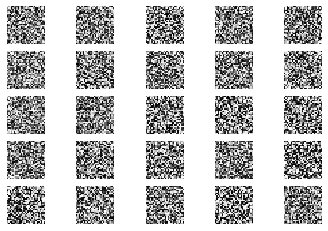

c:\python37\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.608151, acc.: 53.12%] [G loss: 0.586024]
2 [D loss: 0.448988, acc.: 62.50%] [G loss: 0.784969]
3 [D loss: 0.360129, acc.: 78.12%] [G loss: 0.903228]
4 [D loss: 0.276004, acc.: 95.31%] [G loss: 1.122754]
5 [D loss: 0.220229, acc.: 95.31%] [G loss: 1.193773]
6 [D loss: 0.226420, acc.: 95.31%] [G loss: 1.345018]
7 [D loss: 0.179557, acc.: 100.00%] [G loss: 1.484602]
8 [D loss: 0.169205, acc.: 100.00%] [G loss: 1.534755]
9 [D loss: 0.159876, acc.: 100.00%] [G loss: 1.610448]
10 [D loss: 0.169440, acc.: 98.44%] [G loss: 1.803454]
11 [D loss: 0.122983, acc.: 100.00%] [G loss: 1.939540]
12 [D loss: 0.113865, acc.: 100.00%] [G loss: 2.040287]
13 [D loss: 0.103329, acc.: 100.00%] [G loss: 2.057096]
14 [D loss: 0.073785, acc.: 100.00%] [G loss: 2.210657]
15 [D loss: 0.074477, acc.: 100.00%] [G loss: 2.093658]
16 [D loss: 0.101284, acc.: 98.44%] [G loss: 2.262454]
17 [D loss: 0.087202, acc.: 100.00%] [G loss: 2.336298]
18 [D loss: 0.080096, acc.: 100.00%] [G loss: 2.383131]
19 [D los

149 [D loss: 0.176258, acc.: 93.75%] [G loss: 3.687207]
150 [D loss: 0.240598, acc.: 89.06%] [G loss: 3.482033]
151 [D loss: 0.167460, acc.: 90.62%] [G loss: 3.352289]
152 [D loss: 0.205378, acc.: 90.62%] [G loss: 3.346125]
153 [D loss: 0.198847, acc.: 90.62%] [G loss: 3.528393]
154 [D loss: 0.173324, acc.: 96.88%] [G loss: 3.435994]
155 [D loss: 0.154065, acc.: 96.88%] [G loss: 3.394738]
156 [D loss: 0.143488, acc.: 98.44%] [G loss: 3.261512]
157 [D loss: 0.101187, acc.: 96.88%] [G loss: 3.582737]
158 [D loss: 0.138765, acc.: 95.31%] [G loss: 3.579375]
159 [D loss: 0.230972, acc.: 90.62%] [G loss: 3.617113]
160 [D loss: 0.454229, acc.: 81.25%] [G loss: 2.929571]
161 [D loss: 0.103491, acc.: 96.88%] [G loss: 3.695409]
162 [D loss: 0.203621, acc.: 90.62%] [G loss: 3.160220]
163 [D loss: 0.199611, acc.: 90.62%] [G loss: 3.447907]
164 [D loss: 0.261818, acc.: 85.94%] [G loss: 3.065887]
165 [D loss: 0.272334, acc.: 85.94%] [G loss: 3.871524]
166 [D loss: 0.410357, acc.: 78.12%] [G loss: 2.

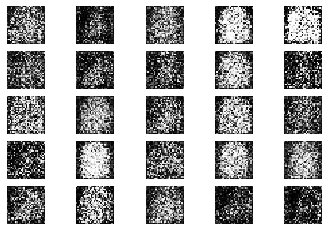

201 [D loss: 0.219073, acc.: 93.75%] [G loss: 3.447388]
202 [D loss: 0.407961, acc.: 81.25%] [G loss: 2.780920]
203 [D loss: 0.314144, acc.: 90.62%] [G loss: 3.100648]
204 [D loss: 0.418033, acc.: 79.69%] [G loss: 4.141797]
205 [D loss: 1.384857, acc.: 34.38%] [G loss: 1.346636]
206 [D loss: 0.436206, acc.: 75.00%] [G loss: 3.058245]
207 [D loss: 0.133918, acc.: 100.00%] [G loss: 3.520466]
208 [D loss: 0.297191, acc.: 85.94%] [G loss: 2.557532]
209 [D loss: 0.367911, acc.: 85.94%] [G loss: 2.615257]
210 [D loss: 0.320352, acc.: 87.50%] [G loss: 2.750896]
211 [D loss: 0.324964, acc.: 85.94%] [G loss: 2.520593]
212 [D loss: 0.363735, acc.: 89.06%] [G loss: 3.036496]
213 [D loss: 0.484441, acc.: 73.44%] [G loss: 2.045568]
214 [D loss: 0.308511, acc.: 85.94%] [G loss: 2.989985]
215 [D loss: 0.375550, acc.: 84.38%] [G loss: 3.407066]
216 [D loss: 0.561131, acc.: 81.25%] [G loss: 2.385044]
217 [D loss: 0.447777, acc.: 79.69%] [G loss: 2.887251]
218 [D loss: 0.551812, acc.: 76.56%] [G loss: 2

349 [D loss: 0.655346, acc.: 54.69%] [G loss: 1.068421]
350 [D loss: 0.729655, acc.: 60.94%] [G loss: 1.106049]
351 [D loss: 0.762926, acc.: 40.62%] [G loss: 1.062636]
352 [D loss: 0.693677, acc.: 56.25%] [G loss: 1.098351]
353 [D loss: 0.713313, acc.: 56.25%] [G loss: 1.014831]
354 [D loss: 0.675201, acc.: 54.69%] [G loss: 1.057740]
355 [D loss: 0.619979, acc.: 68.75%] [G loss: 1.023307]
356 [D loss: 0.572631, acc.: 70.31%] [G loss: 1.169839]
357 [D loss: 0.679277, acc.: 64.06%] [G loss: 1.035790]
358 [D loss: 0.753342, acc.: 51.56%] [G loss: 0.978404]
359 [D loss: 0.630093, acc.: 70.31%] [G loss: 1.131720]
360 [D loss: 0.738832, acc.: 57.81%] [G loss: 1.030760]
361 [D loss: 0.639241, acc.: 59.38%] [G loss: 1.075142]
362 [D loss: 0.666637, acc.: 64.06%] [G loss: 1.052698]
363 [D loss: 0.605730, acc.: 70.31%] [G loss: 1.100509]
364 [D loss: 0.585337, acc.: 70.31%] [G loss: 1.134009]
365 [D loss: 0.768345, acc.: 51.56%] [G loss: 1.048810]
366 [D loss: 0.605814, acc.: 68.75%] [G loss: 1.

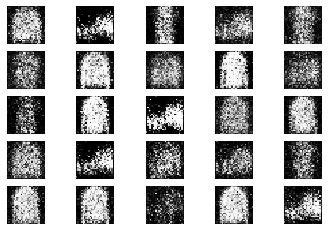

401 [D loss: 0.736590, acc.: 48.44%] [G loss: 0.954383]
402 [D loss: 0.733016, acc.: 50.00%] [G loss: 1.045736]
403 [D loss: 0.601076, acc.: 67.19%] [G loss: 1.096871]
404 [D loss: 0.703179, acc.: 56.25%] [G loss: 0.931032]
405 [D loss: 0.572745, acc.: 78.12%] [G loss: 1.022984]
406 [D loss: 0.734565, acc.: 50.00%] [G loss: 0.935611]
407 [D loss: 0.563020, acc.: 70.31%] [G loss: 0.992640]
408 [D loss: 0.604832, acc.: 67.19%] [G loss: 1.064112]
409 [D loss: 0.619580, acc.: 70.31%] [G loss: 1.040643]
410 [D loss: 0.667387, acc.: 60.94%] [G loss: 1.062892]
411 [D loss: 0.566958, acc.: 70.31%] [G loss: 1.120402]
412 [D loss: 0.700670, acc.: 54.69%] [G loss: 1.065170]
413 [D loss: 0.640120, acc.: 67.19%] [G loss: 1.065113]
414 [D loss: 0.564214, acc.: 73.44%] [G loss: 0.999030]
415 [D loss: 0.626976, acc.: 65.62%] [G loss: 1.053748]
416 [D loss: 0.667143, acc.: 68.75%] [G loss: 1.038201]
417 [D loss: 0.598882, acc.: 73.44%] [G loss: 1.068265]
418 [D loss: 0.579358, acc.: 67.19%] [G loss: 1.

549 [D loss: 0.546544, acc.: 65.62%] [G loss: 0.975775]
550 [D loss: 0.620975, acc.: 68.75%] [G loss: 1.014912]
551 [D loss: 0.600249, acc.: 71.88%] [G loss: 0.956522]
552 [D loss: 0.593855, acc.: 67.19%] [G loss: 0.949895]
553 [D loss: 0.637021, acc.: 60.94%] [G loss: 0.941944]
554 [D loss: 0.561697, acc.: 78.12%] [G loss: 0.956889]
555 [D loss: 0.664753, acc.: 54.69%] [G loss: 0.950060]
556 [D loss: 0.668383, acc.: 54.69%] [G loss: 0.828434]
557 [D loss: 0.718471, acc.: 53.12%] [G loss: 0.899609]
558 [D loss: 0.680202, acc.: 62.50%] [G loss: 0.824187]
559 [D loss: 0.558371, acc.: 76.56%] [G loss: 0.979954]
560 [D loss: 0.608396, acc.: 70.31%] [G loss: 1.008487]
561 [D loss: 0.712937, acc.: 59.38%] [G loss: 1.007451]
562 [D loss: 0.652481, acc.: 59.38%] [G loss: 0.987073]
563 [D loss: 0.757386, acc.: 48.44%] [G loss: 0.958227]
564 [D loss: 0.671570, acc.: 56.25%] [G loss: 1.002506]
565 [D loss: 0.711373, acc.: 51.56%] [G loss: 1.008424]
566 [D loss: 0.606144, acc.: 67.19%] [G loss: 0.

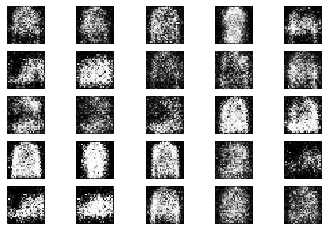

601 [D loss: 0.609195, acc.: 71.88%] [G loss: 0.833522]
602 [D loss: 0.625890, acc.: 59.38%] [G loss: 0.863885]
603 [D loss: 0.622333, acc.: 64.06%] [G loss: 0.928705]
604 [D loss: 0.614105, acc.: 67.19%] [G loss: 0.868653]
605 [D loss: 0.604187, acc.: 67.19%] [G loss: 0.860220]
606 [D loss: 0.582576, acc.: 68.75%] [G loss: 0.828964]
607 [D loss: 0.650402, acc.: 65.62%] [G loss: 0.961815]
608 [D loss: 0.649831, acc.: 68.75%] [G loss: 0.938945]
609 [D loss: 0.652549, acc.: 64.06%] [G loss: 0.886246]
610 [D loss: 0.570445, acc.: 75.00%] [G loss: 0.898489]
611 [D loss: 0.619427, acc.: 64.06%] [G loss: 0.899674]
612 [D loss: 0.639585, acc.: 56.25%] [G loss: 0.866173]
613 [D loss: 0.646267, acc.: 60.94%] [G loss: 0.911452]
614 [D loss: 0.653550, acc.: 60.94%] [G loss: 1.004156]
615 [D loss: 0.648969, acc.: 59.38%] [G loss: 0.940813]
616 [D loss: 0.678118, acc.: 59.38%] [G loss: 0.933784]
617 [D loss: 0.590381, acc.: 67.19%] [G loss: 0.900580]
618 [D loss: 0.590159, acc.: 64.06%] [G loss: 0.

748 [D loss: 0.634993, acc.: 64.06%] [G loss: 0.811006]
749 [D loss: 0.609981, acc.: 68.75%] [G loss: 0.811292]
750 [D loss: 0.666435, acc.: 65.62%] [G loss: 0.818070]
751 [D loss: 0.628555, acc.: 62.50%] [G loss: 0.889956]
752 [D loss: 0.683653, acc.: 56.25%] [G loss: 0.854869]
753 [D loss: 0.589306, acc.: 76.56%] [G loss: 0.871984]
754 [D loss: 0.631345, acc.: 68.75%] [G loss: 0.909414]
755 [D loss: 0.616992, acc.: 67.19%] [G loss: 0.861302]
756 [D loss: 0.673401, acc.: 56.25%] [G loss: 0.840309]
757 [D loss: 0.612434, acc.: 65.62%] [G loss: 0.842414]
758 [D loss: 0.604016, acc.: 71.88%] [G loss: 0.881003]
759 [D loss: 0.569495, acc.: 68.75%] [G loss: 0.914863]
760 [D loss: 0.549188, acc.: 76.56%] [G loss: 0.930887]
761 [D loss: 0.594492, acc.: 64.06%] [G loss: 0.912229]
762 [D loss: 0.636770, acc.: 65.62%] [G loss: 0.878367]
763 [D loss: 0.655658, acc.: 54.69%] [G loss: 0.857367]
764 [D loss: 0.634814, acc.: 62.50%] [G loss: 0.921811]
765 [D loss: 0.658302, acc.: 59.38%] [G loss: 0.

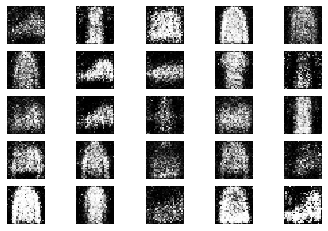

801 [D loss: 0.664722, acc.: 60.94%] [G loss: 0.885310]
802 [D loss: 0.582538, acc.: 75.00%] [G loss: 0.919641]
803 [D loss: 0.679619, acc.: 64.06%] [G loss: 0.935171]
804 [D loss: 0.580423, acc.: 70.31%] [G loss: 0.838196]
805 [D loss: 0.626267, acc.: 67.19%] [G loss: 0.935577]
806 [D loss: 0.609357, acc.: 73.44%] [G loss: 0.885710]
807 [D loss: 0.594483, acc.: 64.06%] [G loss: 0.959853]
808 [D loss: 0.640677, acc.: 59.38%] [G loss: 0.878634]
809 [D loss: 0.669741, acc.: 54.69%] [G loss: 0.861387]
810 [D loss: 0.593699, acc.: 71.88%] [G loss: 0.887734]
811 [D loss: 0.679964, acc.: 62.50%] [G loss: 0.931301]
812 [D loss: 0.652096, acc.: 67.19%] [G loss: 0.929537]
813 [D loss: 0.643356, acc.: 60.94%] [G loss: 0.930026]
814 [D loss: 0.624622, acc.: 64.06%] [G loss: 0.964569]
815 [D loss: 0.664740, acc.: 59.38%] [G loss: 0.915950]
816 [D loss: 0.604198, acc.: 68.75%] [G loss: 0.877125]
817 [D loss: 0.600419, acc.: 73.44%] [G loss: 0.831415]
818 [D loss: 0.649800, acc.: 54.69%] [G loss: 0.

950 [D loss: 0.632674, acc.: 64.06%] [G loss: 0.895780]
951 [D loss: 0.629376, acc.: 64.06%] [G loss: 0.911360]
952 [D loss: 0.654074, acc.: 62.50%] [G loss: 0.872125]
953 [D loss: 0.663946, acc.: 57.81%] [G loss: 0.871055]
954 [D loss: 0.641866, acc.: 62.50%] [G loss: 0.909405]
955 [D loss: 0.668670, acc.: 59.38%] [G loss: 0.833058]
956 [D loss: 0.672507, acc.: 59.38%] [G loss: 0.878236]
957 [D loss: 0.655380, acc.: 59.38%] [G loss: 0.898251]
958 [D loss: 0.629405, acc.: 65.62%] [G loss: 0.901757]
959 [D loss: 0.647721, acc.: 62.50%] [G loss: 0.838540]
960 [D loss: 0.675741, acc.: 56.25%] [G loss: 0.804731]
961 [D loss: 0.645556, acc.: 68.75%] [G loss: 0.841672]
962 [D loss: 0.617200, acc.: 67.19%] [G loss: 0.962092]
963 [D loss: 0.690870, acc.: 53.12%] [G loss: 0.823971]
964 [D loss: 0.651058, acc.: 54.69%] [G loss: 0.834153]
965 [D loss: 0.655480, acc.: 60.94%] [G loss: 0.854676]
966 [D loss: 0.671854, acc.: 62.50%] [G loss: 0.909126]
967 [D loss: 0.616801, acc.: 67.19%] [G loss: 0.

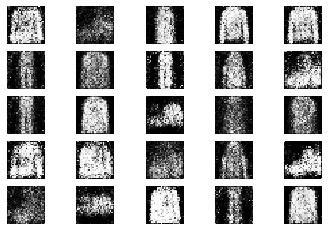

1001 [D loss: 0.666129, acc.: 56.25%] [G loss: 0.871322]
1002 [D loss: 0.639783, acc.: 67.19%] [G loss: 0.845384]
1003 [D loss: 0.655540, acc.: 64.06%] [G loss: 0.832702]
1004 [D loss: 0.688686, acc.: 51.56%] [G loss: 0.818606]
1005 [D loss: 0.648009, acc.: 64.06%] [G loss: 0.789927]
1006 [D loss: 0.605091, acc.: 65.62%] [G loss: 0.770627]
1007 [D loss: 0.711295, acc.: 48.44%] [G loss: 0.822772]
1008 [D loss: 0.648174, acc.: 56.25%] [G loss: 0.743421]
1009 [D loss: 0.660489, acc.: 57.81%] [G loss: 0.791273]
1010 [D loss: 0.597692, acc.: 71.88%] [G loss: 0.834202]
1011 [D loss: 0.633271, acc.: 62.50%] [G loss: 0.765976]
1012 [D loss: 0.687816, acc.: 53.12%] [G loss: 0.855057]
1013 [D loss: 0.702083, acc.: 50.00%] [G loss: 0.778956]
1014 [D loss: 0.632484, acc.: 60.94%] [G loss: 0.826452]
1015 [D loss: 0.663149, acc.: 54.69%] [G loss: 0.823051]
1016 [D loss: 0.669122, acc.: 57.81%] [G loss: 0.781932]
1017 [D loss: 0.651691, acc.: 65.62%] [G loss: 0.820817]
1018 [D loss: 0.686945, acc.: 5

1145 [D loss: 0.618111, acc.: 60.94%] [G loss: 0.781275]
1146 [D loss: 0.632824, acc.: 65.62%] [G loss: 0.803907]
1147 [D loss: 0.618499, acc.: 67.19%] [G loss: 0.843385]
1148 [D loss: 0.677346, acc.: 67.19%] [G loss: 0.879861]
1149 [D loss: 0.633522, acc.: 65.62%] [G loss: 0.932927]
1150 [D loss: 0.636460, acc.: 65.62%] [G loss: 0.899672]
1151 [D loss: 0.667668, acc.: 53.12%] [G loss: 0.822767]
1152 [D loss: 0.625041, acc.: 67.19%] [G loss: 0.838173]
1153 [D loss: 0.651084, acc.: 64.06%] [G loss: 0.850488]
1154 [D loss: 0.658179, acc.: 62.50%] [G loss: 0.819315]
1155 [D loss: 0.634689, acc.: 64.06%] [G loss: 0.826599]
1156 [D loss: 0.657677, acc.: 64.06%] [G loss: 0.792212]
1157 [D loss: 0.642242, acc.: 67.19%] [G loss: 0.837218]
1158 [D loss: 0.633159, acc.: 62.50%] [G loss: 0.801295]
1159 [D loss: 0.641187, acc.: 68.75%] [G loss: 0.778201]
1160 [D loss: 0.597228, acc.: 73.44%] [G loss: 0.919723]
1161 [D loss: 0.683491, acc.: 59.38%] [G loss: 0.864404]
1162 [D loss: 0.642954, acc.: 6

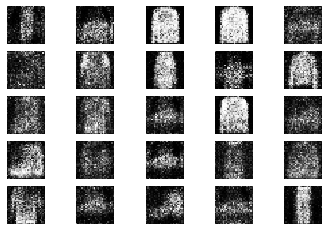

1201 [D loss: 0.586495, acc.: 67.19%] [G loss: 0.935718]
1202 [D loss: 0.668031, acc.: 56.25%] [G loss: 0.873043]
1203 [D loss: 0.650447, acc.: 64.06%] [G loss: 0.863600]
1204 [D loss: 0.641510, acc.: 64.06%] [G loss: 0.827510]
1205 [D loss: 0.603278, acc.: 65.62%] [G loss: 0.821859]
1206 [D loss: 0.645166, acc.: 64.06%] [G loss: 0.800920]
1207 [D loss: 0.630943, acc.: 68.75%] [G loss: 0.797221]
1208 [D loss: 0.651019, acc.: 62.50%] [G loss: 0.777304]
1209 [D loss: 0.655937, acc.: 65.62%] [G loss: 0.787767]
1210 [D loss: 0.626910, acc.: 68.75%] [G loss: 0.841391]
1211 [D loss: 0.591414, acc.: 67.19%] [G loss: 0.824385]
1212 [D loss: 0.643786, acc.: 64.06%] [G loss: 0.960667]
1213 [D loss: 0.660136, acc.: 57.81%] [G loss: 0.961714]
1214 [D loss: 0.612481, acc.: 65.62%] [G loss: 0.826570]
1215 [D loss: 0.649716, acc.: 60.94%] [G loss: 0.897833]
1216 [D loss: 0.694685, acc.: 54.69%] [G loss: 0.858703]
1217 [D loss: 0.656824, acc.: 59.38%] [G loss: 0.899876]
1218 [D loss: 0.591076, acc.: 6

1346 [D loss: 0.664641, acc.: 62.50%] [G loss: 0.781995]
1347 [D loss: 0.677429, acc.: 64.06%] [G loss: 0.782353]
1348 [D loss: 0.629611, acc.: 64.06%] [G loss: 0.896663]
1349 [D loss: 0.643541, acc.: 68.75%] [G loss: 0.811625]
1350 [D loss: 0.630260, acc.: 62.50%] [G loss: 0.845719]
1351 [D loss: 0.594091, acc.: 71.88%] [G loss: 0.904317]
1352 [D loss: 0.649652, acc.: 60.94%] [G loss: 0.802270]
1353 [D loss: 0.580614, acc.: 71.88%] [G loss: 0.818478]
1354 [D loss: 0.543085, acc.: 78.12%] [G loss: 0.870036]
1355 [D loss: 0.618967, acc.: 68.75%] [G loss: 0.872148]
1356 [D loss: 0.660237, acc.: 57.81%] [G loss: 0.832540]
1357 [D loss: 0.622317, acc.: 71.88%] [G loss: 0.819773]
1358 [D loss: 0.604201, acc.: 65.62%] [G loss: 0.802290]
1359 [D loss: 0.647123, acc.: 62.50%] [G loss: 0.890471]
1360 [D loss: 0.710997, acc.: 56.25%] [G loss: 0.871863]
1361 [D loss: 0.643656, acc.: 62.50%] [G loss: 0.860298]
1362 [D loss: 0.632243, acc.: 59.38%] [G loss: 0.903671]
1363 [D loss: 0.654041, acc.: 6

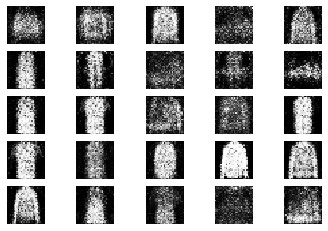

1401 [D loss: 0.578537, acc.: 71.88%] [G loss: 0.907517]
1402 [D loss: 0.599629, acc.: 71.88%] [G loss: 0.829461]
1403 [D loss: 0.673666, acc.: 56.25%] [G loss: 0.884298]
1404 [D loss: 0.677523, acc.: 53.12%] [G loss: 0.881958]
1405 [D loss: 0.633580, acc.: 62.50%] [G loss: 0.921426]
1406 [D loss: 0.533749, acc.: 78.12%] [G loss: 0.929403]
1407 [D loss: 0.662707, acc.: 59.38%] [G loss: 0.879143]
1408 [D loss: 0.587504, acc.: 67.19%] [G loss: 0.879065]
1409 [D loss: 0.603526, acc.: 64.06%] [G loss: 0.948877]
1410 [D loss: 0.645759, acc.: 60.94%] [G loss: 0.983637]
1411 [D loss: 0.633978, acc.: 60.94%] [G loss: 0.952469]
1412 [D loss: 0.625496, acc.: 65.62%] [G loss: 0.851644]
1413 [D loss: 0.601552, acc.: 68.75%] [G loss: 0.991265]
1414 [D loss: 0.633548, acc.: 64.06%] [G loss: 0.950495]
1415 [D loss: 0.643047, acc.: 65.62%] [G loss: 0.896514]
1416 [D loss: 0.674122, acc.: 57.81%] [G loss: 0.826279]
1417 [D loss: 0.681155, acc.: 56.25%] [G loss: 0.807389]
1418 [D loss: 0.651739, acc.: 6

1546 [D loss: 0.593839, acc.: 68.75%] [G loss: 0.789051]
1547 [D loss: 0.616469, acc.: 60.94%] [G loss: 0.796828]
1548 [D loss: 0.592014, acc.: 64.06%] [G loss: 0.832928]
1549 [D loss: 0.604867, acc.: 60.94%] [G loss: 0.993339]
1550 [D loss: 0.697007, acc.: 54.69%] [G loss: 0.911901]
1551 [D loss: 0.623857, acc.: 71.88%] [G loss: 0.903952]
1552 [D loss: 0.586108, acc.: 70.31%] [G loss: 0.900911]
1553 [D loss: 0.582424, acc.: 79.69%] [G loss: 0.935043]
1554 [D loss: 0.612642, acc.: 67.19%] [G loss: 0.843753]
1555 [D loss: 0.597946, acc.: 70.31%] [G loss: 0.906436]
1556 [D loss: 0.627837, acc.: 60.94%] [G loss: 0.958471]
1557 [D loss: 0.689174, acc.: 57.81%] [G loss: 0.899565]
1558 [D loss: 0.631110, acc.: 65.62%] [G loss: 0.939830]
1559 [D loss: 0.617447, acc.: 65.62%] [G loss: 0.917030]
1560 [D loss: 0.615539, acc.: 67.19%] [G loss: 0.883137]
1561 [D loss: 0.604706, acc.: 71.88%] [G loss: 1.065234]
1562 [D loss: 0.608249, acc.: 68.75%] [G loss: 0.834107]
1563 [D loss: 0.552812, acc.: 7

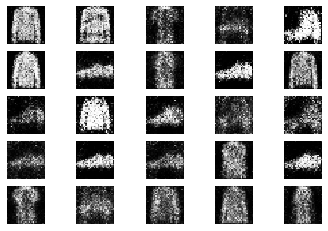

1601 [D loss: 0.631358, acc.: 64.06%] [G loss: 0.834511]
1602 [D loss: 0.566501, acc.: 75.00%] [G loss: 0.853730]
1603 [D loss: 0.710350, acc.: 50.00%] [G loss: 0.925380]
1604 [D loss: 0.563337, acc.: 75.00%] [G loss: 0.903837]
1605 [D loss: 0.645832, acc.: 59.38%] [G loss: 0.901542]
1606 [D loss: 0.634198, acc.: 59.38%] [G loss: 0.959926]
1607 [D loss: 0.633907, acc.: 60.94%] [G loss: 0.876158]
1608 [D loss: 0.634810, acc.: 59.38%] [G loss: 0.844204]
1609 [D loss: 0.666584, acc.: 60.94%] [G loss: 0.963537]
1610 [D loss: 0.561653, acc.: 81.25%] [G loss: 0.931120]
1611 [D loss: 0.654782, acc.: 56.25%] [G loss: 0.906699]
1612 [D loss: 0.640450, acc.: 59.38%] [G loss: 0.833517]
1613 [D loss: 0.686130, acc.: 60.94%] [G loss: 0.830615]
1614 [D loss: 0.654385, acc.: 54.69%] [G loss: 0.875395]
1615 [D loss: 0.573625, acc.: 73.44%] [G loss: 0.982463]
1616 [D loss: 0.605583, acc.: 68.75%] [G loss: 0.869330]
1617 [D loss: 0.584486, acc.: 68.75%] [G loss: 0.899397]
1618 [D loss: 0.646571, acc.: 6

1747 [D loss: 0.763631, acc.: 54.69%] [G loss: 0.929297]
1748 [D loss: 0.650935, acc.: 60.94%] [G loss: 0.934746]
1749 [D loss: 0.605954, acc.: 64.06%] [G loss: 0.917843]
1750 [D loss: 0.598894, acc.: 68.75%] [G loss: 0.887066]
1751 [D loss: 0.610780, acc.: 73.44%] [G loss: 0.901452]
1752 [D loss: 0.614062, acc.: 70.31%] [G loss: 0.965180]
1753 [D loss: 0.689158, acc.: 65.62%] [G loss: 0.900154]
1754 [D loss: 0.623393, acc.: 64.06%] [G loss: 0.843654]
1755 [D loss: 0.621455, acc.: 60.94%] [G loss: 0.875910]
1756 [D loss: 0.568436, acc.: 65.62%] [G loss: 0.951395]
1757 [D loss: 0.695915, acc.: 56.25%] [G loss: 0.969159]
1758 [D loss: 0.646694, acc.: 59.38%] [G loss: 0.988345]
1759 [D loss: 0.562293, acc.: 75.00%] [G loss: 0.919736]
1760 [D loss: 0.600240, acc.: 65.62%] [G loss: 0.878998]
1761 [D loss: 0.579162, acc.: 70.31%] [G loss: 0.847880]
1762 [D loss: 0.668232, acc.: 57.81%] [G loss: 0.982427]
1763 [D loss: 0.621833, acc.: 70.31%] [G loss: 0.929144]
1764 [D loss: 0.641038, acc.: 6

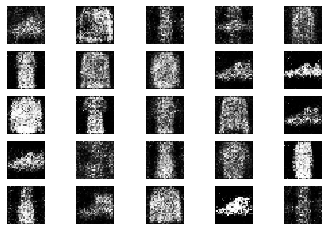

1801 [D loss: 0.611960, acc.: 62.50%] [G loss: 0.814723]
1802 [D loss: 0.552723, acc.: 67.19%] [G loss: 0.931255]
1803 [D loss: 0.619992, acc.: 62.50%] [G loss: 0.964380]
1804 [D loss: 0.638611, acc.: 59.38%] [G loss: 0.974088]
1805 [D loss: 0.607136, acc.: 62.50%] [G loss: 0.837853]
1806 [D loss: 0.647284, acc.: 54.69%] [G loss: 0.948553]
1807 [D loss: 0.598851, acc.: 62.50%] [G loss: 0.941829]
1808 [D loss: 0.661713, acc.: 57.81%] [G loss: 0.926331]
1809 [D loss: 0.696495, acc.: 57.81%] [G loss: 0.891343]
1810 [D loss: 0.715250, acc.: 45.31%] [G loss: 0.994423]
1811 [D loss: 0.635732, acc.: 59.38%] [G loss: 0.930621]
1812 [D loss: 0.653340, acc.: 54.69%] [G loss: 0.896926]
1813 [D loss: 0.603335, acc.: 71.88%] [G loss: 0.944796]
1814 [D loss: 0.607646, acc.: 64.06%] [G loss: 0.885824]
1815 [D loss: 0.642399, acc.: 60.94%] [G loss: 0.906091]
1816 [D loss: 0.612117, acc.: 60.94%] [G loss: 0.897162]
1817 [D loss: 0.649133, acc.: 67.19%] [G loss: 0.912546]
1818 [D loss: 0.629495, acc.: 6

1946 [D loss: 0.691216, acc.: 59.38%] [G loss: 0.917474]
1947 [D loss: 0.600702, acc.: 76.56%] [G loss: 0.885051]
1948 [D loss: 0.634270, acc.: 65.62%] [G loss: 0.853245]
1949 [D loss: 0.631996, acc.: 62.50%] [G loss: 0.887872]
1950 [D loss: 0.613250, acc.: 65.62%] [G loss: 0.872272]
1951 [D loss: 0.648989, acc.: 57.81%] [G loss: 0.865265]
1952 [D loss: 0.626504, acc.: 70.31%] [G loss: 0.862239]
1953 [D loss: 0.697651, acc.: 53.12%] [G loss: 0.851414]
1954 [D loss: 0.592229, acc.: 65.62%] [G loss: 0.939634]
1955 [D loss: 0.671294, acc.: 57.81%] [G loss: 0.816457]
1956 [D loss: 0.691268, acc.: 60.94%] [G loss: 0.909404]
1957 [D loss: 0.658402, acc.: 65.62%] [G loss: 0.869692]
1958 [D loss: 0.678618, acc.: 54.69%] [G loss: 0.976300]
1959 [D loss: 0.585777, acc.: 76.56%] [G loss: 0.986694]
1960 [D loss: 0.616812, acc.: 65.62%] [G loss: 1.002084]
1961 [D loss: 0.672384, acc.: 59.38%] [G loss: 0.967395]
1962 [D loss: 0.618633, acc.: 64.06%] [G loss: 0.908591]
1963 [D loss: 0.643957, acc.: 6

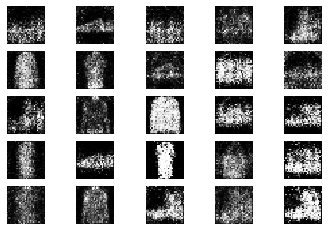

2001 [D loss: 0.604524, acc.: 64.06%] [G loss: 0.949557]
2002 [D loss: 0.647983, acc.: 60.94%] [G loss: 0.938586]
2003 [D loss: 0.612329, acc.: 57.81%] [G loss: 0.893478]
2004 [D loss: 0.657255, acc.: 57.81%] [G loss: 0.954130]
2005 [D loss: 0.580725, acc.: 76.56%] [G loss: 0.959135]
2006 [D loss: 0.604640, acc.: 68.75%] [G loss: 0.825838]
2007 [D loss: 0.665646, acc.: 53.12%] [G loss: 0.899166]
2008 [D loss: 0.600311, acc.: 67.19%] [G loss: 0.904613]
2009 [D loss: 0.642078, acc.: 62.50%] [G loss: 0.865116]
2010 [D loss: 0.622315, acc.: 65.62%] [G loss: 0.945007]
2011 [D loss: 0.568031, acc.: 70.31%] [G loss: 0.879932]
2012 [D loss: 0.642170, acc.: 60.94%] [G loss: 0.863593]
2013 [D loss: 0.555763, acc.: 71.88%] [G loss: 0.911139]
2014 [D loss: 0.641012, acc.: 62.50%] [G loss: 1.050283]
2015 [D loss: 0.753800, acc.: 48.44%] [G loss: 0.873767]
2016 [D loss: 0.619186, acc.: 62.50%] [G loss: 0.889298]
2017 [D loss: 0.596283, acc.: 70.31%] [G loss: 0.933041]
2018 [D loss: 0.611004, acc.: 6

2146 [D loss: 0.672511, acc.: 64.06%] [G loss: 0.991068]
2147 [D loss: 0.664137, acc.: 54.69%] [G loss: 0.824262]
2148 [D loss: 0.663910, acc.: 54.69%] [G loss: 0.884236]
2149 [D loss: 0.594391, acc.: 71.88%] [G loss: 0.842061]
2150 [D loss: 0.620811, acc.: 60.94%] [G loss: 0.871303]
2151 [D loss: 0.592523, acc.: 68.75%] [G loss: 0.938873]
2152 [D loss: 0.661649, acc.: 59.38%] [G loss: 0.908955]
2153 [D loss: 0.658121, acc.: 65.62%] [G loss: 0.916142]
2154 [D loss: 0.552336, acc.: 70.31%] [G loss: 0.925015]
2155 [D loss: 0.622782, acc.: 56.25%] [G loss: 0.867197]
2156 [D loss: 0.712063, acc.: 54.69%] [G loss: 0.927543]
2157 [D loss: 0.631895, acc.: 56.25%] [G loss: 1.010306]
2158 [D loss: 0.600568, acc.: 70.31%] [G loss: 1.023692]
2159 [D loss: 0.556536, acc.: 70.31%] [G loss: 1.010517]
2160 [D loss: 0.576332, acc.: 71.88%] [G loss: 0.980130]
2161 [D loss: 0.623879, acc.: 59.38%] [G loss: 0.958812]
2162 [D loss: 0.634494, acc.: 59.38%] [G loss: 0.910972]
2163 [D loss: 0.624212, acc.: 6

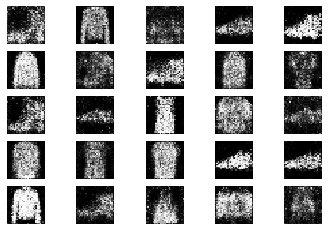

2201 [D loss: 0.585457, acc.: 70.31%] [G loss: 0.907339]
2202 [D loss: 0.656053, acc.: 60.94%] [G loss: 0.920227]
2203 [D loss: 0.624590, acc.: 60.94%] [G loss: 0.962179]
2204 [D loss: 0.618381, acc.: 64.06%] [G loss: 0.965968]
2205 [D loss: 0.477875, acc.: 82.81%] [G loss: 0.956916]
2206 [D loss: 0.582467, acc.: 64.06%] [G loss: 0.916196]
2207 [D loss: 0.669853, acc.: 54.69%] [G loss: 0.874446]
2208 [D loss: 0.608744, acc.: 59.38%] [G loss: 0.966110]
2209 [D loss: 0.675207, acc.: 57.81%] [G loss: 0.961784]
2210 [D loss: 0.593831, acc.: 73.44%] [G loss: 1.015401]
2211 [D loss: 0.561437, acc.: 78.12%] [G loss: 0.935926]
2212 [D loss: 0.702616, acc.: 57.81%] [G loss: 0.914339]
2213 [D loss: 0.630934, acc.: 64.06%] [G loss: 0.949874]
2214 [D loss: 0.604917, acc.: 70.31%] [G loss: 0.936411]
2215 [D loss: 0.621086, acc.: 60.94%] [G loss: 0.845703]
2216 [D loss: 0.581148, acc.: 65.62%] [G loss: 0.939479]
2217 [D loss: 0.681675, acc.: 57.81%] [G loss: 0.852024]
2218 [D loss: 0.665235, acc.: 5

2346 [D loss: 0.638006, acc.: 59.38%] [G loss: 0.879559]
2347 [D loss: 0.690348, acc.: 53.12%] [G loss: 0.852828]
2348 [D loss: 0.719058, acc.: 46.88%] [G loss: 0.941193]
2349 [D loss: 0.553846, acc.: 76.56%] [G loss: 0.855345]
2350 [D loss: 0.610185, acc.: 65.62%] [G loss: 0.922745]
2351 [D loss: 0.591386, acc.: 65.62%] [G loss: 0.883642]
2352 [D loss: 0.650188, acc.: 54.69%] [G loss: 0.965158]
2353 [D loss: 0.580552, acc.: 71.88%] [G loss: 0.942533]
2354 [D loss: 0.653130, acc.: 54.69%] [G loss: 0.951955]
2355 [D loss: 0.571486, acc.: 78.12%] [G loss: 0.998610]
2356 [D loss: 0.592998, acc.: 71.88%] [G loss: 1.013319]
2357 [D loss: 0.628386, acc.: 60.94%] [G loss: 0.862777]
2358 [D loss: 0.620410, acc.: 68.75%] [G loss: 0.905891]
2359 [D loss: 0.599009, acc.: 67.19%] [G loss: 0.936150]
2360 [D loss: 0.664765, acc.: 65.62%] [G loss: 0.857689]
2361 [D loss: 0.626890, acc.: 62.50%] [G loss: 0.810526]
2362 [D loss: 0.636552, acc.: 65.62%] [G loss: 0.848649]
2363 [D loss: 0.649396, acc.: 5

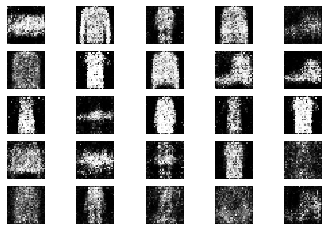

2401 [D loss: 0.604330, acc.: 62.50%] [G loss: 0.956774]
2402 [D loss: 0.614252, acc.: 65.62%] [G loss: 0.905735]
2403 [D loss: 0.661139, acc.: 57.81%] [G loss: 0.867314]
2404 [D loss: 0.604959, acc.: 64.06%] [G loss: 1.024294]
2405 [D loss: 0.569557, acc.: 70.31%] [G loss: 0.975722]
2406 [D loss: 0.596461, acc.: 64.06%] [G loss: 1.049750]
2407 [D loss: 0.671665, acc.: 64.06%] [G loss: 0.949057]
2408 [D loss: 0.709921, acc.: 53.12%] [G loss: 0.893100]
2409 [D loss: 0.651357, acc.: 65.62%] [G loss: 0.914955]
2410 [D loss: 0.590326, acc.: 62.50%] [G loss: 0.952971]
2411 [D loss: 0.637224, acc.: 57.81%] [G loss: 0.939816]
2412 [D loss: 0.582005, acc.: 67.19%] [G loss: 0.954265]
2413 [D loss: 0.630560, acc.: 62.50%] [G loss: 0.921416]
2414 [D loss: 0.583831, acc.: 65.62%] [G loss: 0.896573]
2415 [D loss: 0.647085, acc.: 57.81%] [G loss: 0.898136]
2416 [D loss: 0.658578, acc.: 56.25%] [G loss: 0.885568]
2417 [D loss: 0.645403, acc.: 59.38%] [G loss: 0.940573]
2418 [D loss: 0.567332, acc.: 7

2548 [D loss: 0.633281, acc.: 64.06%] [G loss: 0.924185]
2549 [D loss: 0.643233, acc.: 64.06%] [G loss: 0.987542]
2550 [D loss: 0.608199, acc.: 68.75%] [G loss: 0.869442]
2551 [D loss: 0.624369, acc.: 67.19%] [G loss: 0.877038]
2552 [D loss: 0.633865, acc.: 67.19%] [G loss: 0.845694]
2553 [D loss: 0.598758, acc.: 65.62%] [G loss: 0.901067]
2554 [D loss: 0.666113, acc.: 57.81%] [G loss: 0.918345]
2555 [D loss: 0.574271, acc.: 68.75%] [G loss: 0.943296]
2556 [D loss: 0.609413, acc.: 62.50%] [G loss: 0.900669]
2557 [D loss: 0.650559, acc.: 54.69%] [G loss: 0.936872]
2558 [D loss: 0.648309, acc.: 60.94%] [G loss: 1.018271]
2559 [D loss: 0.680441, acc.: 48.44%] [G loss: 0.963833]
2560 [D loss: 0.643481, acc.: 64.06%] [G loss: 0.974769]
2561 [D loss: 0.713483, acc.: 53.12%] [G loss: 0.942074]
2562 [D loss: 0.623833, acc.: 65.62%] [G loss: 0.904563]
2563 [D loss: 0.613197, acc.: 62.50%] [G loss: 0.913573]
2564 [D loss: 0.619492, acc.: 70.31%] [G loss: 0.854601]
2565 [D loss: 0.657055, acc.: 5

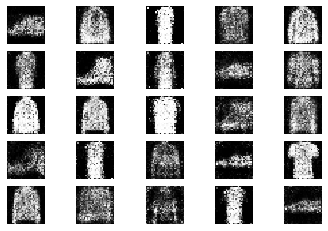

2601 [D loss: 0.571267, acc.: 70.31%] [G loss: 0.965431]
2602 [D loss: 0.674926, acc.: 59.38%] [G loss: 0.900981]
2603 [D loss: 0.602303, acc.: 64.06%] [G loss: 1.027948]
2604 [D loss: 0.598681, acc.: 68.75%] [G loss: 1.007749]
2605 [D loss: 0.627934, acc.: 65.62%] [G loss: 0.992666]
2606 [D loss: 0.539078, acc.: 68.75%] [G loss: 0.990969]
2607 [D loss: 0.578720, acc.: 73.44%] [G loss: 0.967967]
2608 [D loss: 0.636269, acc.: 60.94%] [G loss: 0.955362]
2609 [D loss: 0.604625, acc.: 70.31%] [G loss: 0.991718]
2610 [D loss: 0.624188, acc.: 59.38%] [G loss: 0.933017]
2611 [D loss: 0.653833, acc.: 62.50%] [G loss: 0.998026]
2612 [D loss: 0.634724, acc.: 62.50%] [G loss: 0.962903]
2613 [D loss: 0.613199, acc.: 56.25%] [G loss: 1.062023]
2614 [D loss: 0.648143, acc.: 60.94%] [G loss: 0.856346]
2615 [D loss: 0.596640, acc.: 65.62%] [G loss: 0.932162]
2616 [D loss: 0.646721, acc.: 59.38%] [G loss: 0.881276]
2617 [D loss: 0.615074, acc.: 64.06%] [G loss: 0.887851]
2618 [D loss: 0.585438, acc.: 5

2747 [D loss: 0.681191, acc.: 64.06%] [G loss: 0.847985]
2748 [D loss: 0.647064, acc.: 60.94%] [G loss: 0.870421]
2749 [D loss: 0.639404, acc.: 56.25%] [G loss: 0.913784]
2750 [D loss: 0.671819, acc.: 56.25%] [G loss: 0.940713]
2751 [D loss: 0.552884, acc.: 73.44%] [G loss: 1.000151]
2752 [D loss: 0.649856, acc.: 64.06%] [G loss: 0.921657]
2753 [D loss: 0.698241, acc.: 53.12%] [G loss: 0.856246]
2754 [D loss: 0.640790, acc.: 64.06%] [G loss: 0.886167]
2755 [D loss: 0.703377, acc.: 56.25%] [G loss: 0.867933]
2756 [D loss: 0.585748, acc.: 71.88%] [G loss: 0.938309]
2757 [D loss: 0.620603, acc.: 64.06%] [G loss: 0.937013]
2758 [D loss: 0.650231, acc.: 57.81%] [G loss: 0.938698]
2759 [D loss: 0.665125, acc.: 56.25%] [G loss: 0.947811]
2760 [D loss: 0.585011, acc.: 67.19%] [G loss: 1.024250]
2761 [D loss: 0.633706, acc.: 65.62%] [G loss: 0.943764]
2762 [D loss: 0.574753, acc.: 70.31%] [G loss: 0.960171]
2763 [D loss: 0.618433, acc.: 68.75%] [G loss: 0.929535]
2764 [D loss: 0.633097, acc.: 6

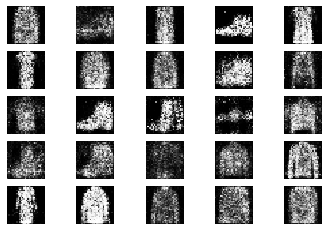

2801 [D loss: 0.620850, acc.: 68.75%] [G loss: 0.980826]
2802 [D loss: 0.640906, acc.: 64.06%] [G loss: 0.908933]
2803 [D loss: 0.671182, acc.: 56.25%] [G loss: 0.986597]
2804 [D loss: 0.587981, acc.: 60.94%] [G loss: 0.935819]
2805 [D loss: 0.657042, acc.: 62.50%] [G loss: 0.916169]
2806 [D loss: 0.652388, acc.: 62.50%] [G loss: 0.944659]
2807 [D loss: 0.578847, acc.: 70.31%] [G loss: 0.897676]
2808 [D loss: 0.625465, acc.: 62.50%] [G loss: 0.969512]
2809 [D loss: 0.622090, acc.: 65.62%] [G loss: 0.907957]
2810 [D loss: 0.570836, acc.: 68.75%] [G loss: 0.970338]
2811 [D loss: 0.641168, acc.: 57.81%] [G loss: 0.868981]
2812 [D loss: 0.511531, acc.: 81.25%] [G loss: 1.062459]
2813 [D loss: 0.621648, acc.: 65.62%] [G loss: 1.006513]
2814 [D loss: 0.541298, acc.: 75.00%] [G loss: 0.923817]
2815 [D loss: 0.567143, acc.: 67.19%] [G loss: 1.028117]
2816 [D loss: 0.713302, acc.: 59.38%] [G loss: 0.910908]
2817 [D loss: 0.654687, acc.: 57.81%] [G loss: 0.871118]
2818 [D loss: 0.619678, acc.: 6

2945 [D loss: 0.688874, acc.: 50.00%] [G loss: 0.982054]
2946 [D loss: 0.630258, acc.: 67.19%] [G loss: 0.958179]
2947 [D loss: 0.646950, acc.: 62.50%] [G loss: 0.893503]
2948 [D loss: 0.582847, acc.: 73.44%] [G loss: 0.873746]
2949 [D loss: 0.611992, acc.: 70.31%] [G loss: 0.935525]
2950 [D loss: 0.587092, acc.: 68.75%] [G loss: 0.926064]
2951 [D loss: 0.576058, acc.: 67.19%] [G loss: 0.882849]
2952 [D loss: 0.615502, acc.: 60.94%] [G loss: 0.954705]
2953 [D loss: 0.575934, acc.: 68.75%] [G loss: 0.924785]
2954 [D loss: 0.629231, acc.: 57.81%] [G loss: 0.938084]
2955 [D loss: 0.643064, acc.: 57.81%] [G loss: 0.887308]
2956 [D loss: 0.696510, acc.: 50.00%] [G loss: 0.880788]
2957 [D loss: 0.585824, acc.: 70.31%] [G loss: 0.934161]
2958 [D loss: 0.632312, acc.: 65.62%] [G loss: 0.975223]
2959 [D loss: 0.584237, acc.: 71.88%] [G loss: 0.968998]
2960 [D loss: 0.669705, acc.: 56.25%] [G loss: 0.882611]
2961 [D loss: 0.707049, acc.: 59.38%] [G loss: 0.922450]
2962 [D loss: 0.634406, acc.: 5

In [4]:


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3000, batch_size=32, sample_interval=200)